In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 16
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

import covid19

## data

In [3]:
data = pd.read_csv('covid-19-it-protezione-civile.csv', parse_dates=['date'], index_col=['date'])
data['total_cases'] = data['cases'] + data['deaths'] + data['healed']

data

,cases,deaths,healed,critical,severe,total_cases
date,,,,,,
2020-02-21 16:00:00,19,1,0,0,0,20
2020-02-22 16:00:00,74,2,0,0,0,76
2020-02-23 16:00:00,149,3,0,0,0,152
2020-02-24 16:00:00,222,7,0,27,101,229
2020-02-25 16:00:00,311,10,1,35,114,322
2020-02-26 16:00:00,385,12,3,36,128,400
2020-02-27 16:00:00,588,17,45,56,248,650
2020-02-28 16:00:00,821,21,46,64,345,888
2020-02-29 16:00:00,1049,29,50,105,401,1128


## situation report

In [4]:
START_FIT = '2020-02-24'
STOP_FIT = None
EXTRAPOLTATE = ('2020-02-20T16:00', '2020-03-09')

In [5]:
fits = {}
for kind in data.columns:
    fits[kind] = covid19.fit.ExponentialFit.from_frame(kind, data, start=START_FIT, stop=STOP_FIT)

../covid19/fit.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_y = np.log2(data_fit[y].values)


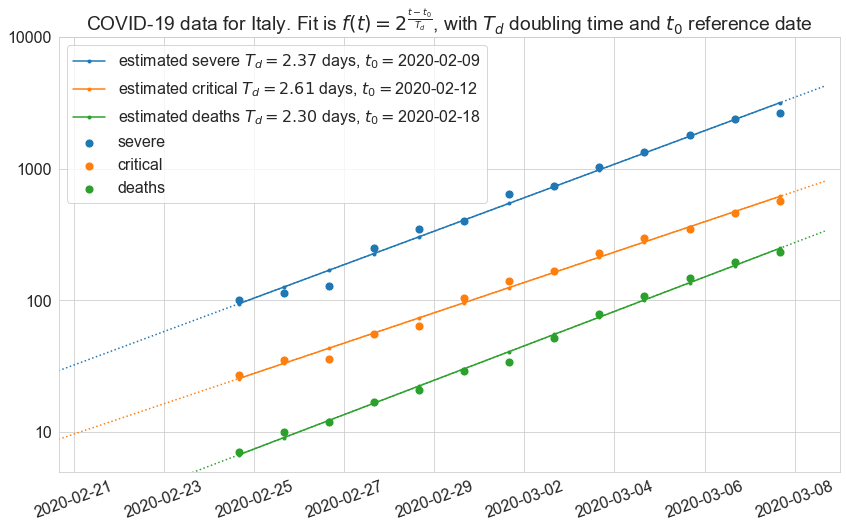

In [6]:
_, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (5, 10000)})
for kind, color in zip(['severe', 'critical', 'deaths'], sns.color_palette()):
    covid19.plot.plot(ax, data[kind], fits[kind], label=kind, extrapolate=EXTRAPOLTATE, color=color)

_ = ax.set(title=r'COVID-19 data for Italy. Fit is $f(t) = 2 ^ \frac{t - t_0}{T_d}$, with $T_d$ doubling time and $t_0$ reference date')

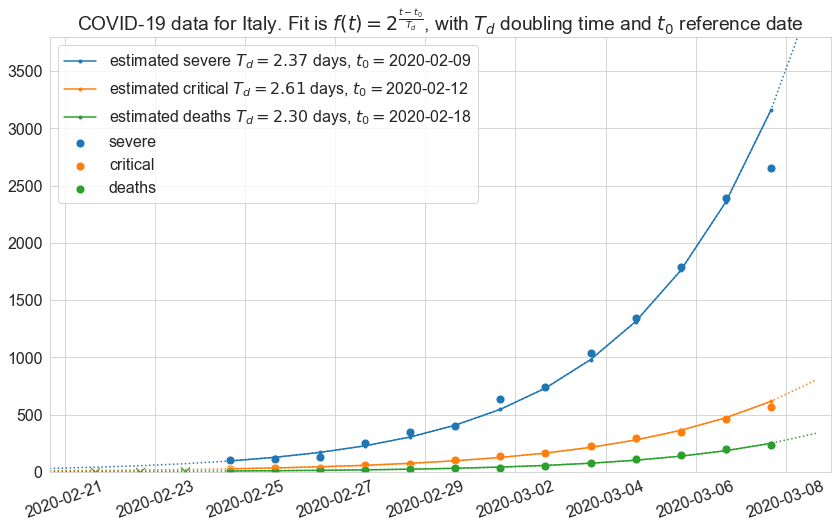

In [7]:
_, ax = plt.subplots(subplot_kw={'ylim': (0, 3800)})
for kind, color in zip(['severe', 'critical', 'deaths'], sns.color_palette()):
    covid19.plot.plot(ax, data[kind], fits[kind], label=kind, extrapolate=EXTRAPOLTATE, color=color)

_ = ax.set(title=r'COVID-19 data for Italy. Fit is $f(t) = 2 ^ \frac{t - t_0}{T_d}$, with $T_d$ doubling time and $t_0$ reference date')

## estimates

In [8]:
kinds = ['deaths', 'critical', 'severe', 'healed']
datetime_expected = '2020-03-08T16:00'
expected_values = []
for kind in kinds:
    expected_values.append(int(round(fits[kind].predict(datetime_expected))))
print(', '.join(f'{k}: {v}' for v, k in zip(expected_values, kinds)))

deaths: 335, critical: 801, severe: 4231, healed: 1878
